## IRIS Slit Jaw Image Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import astropy.io
from astropy.io import fits
sji = fits.open('iris_l2_20130913_063651_4004255648_SJI_1400_t000.fits.gz')

In [2]:
print(dir(sji))

['__add__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_data', '_file', '_flush_resize', '_flush_update', '_in_read_next_hdu', '_open_kwargs', '_positive_index_of', '_read_all', '_read_next_hdu', '_readfrom', '_resize', '_truncate', '_try_while_unread_hdus', '_verify', '_wasresized', 'append', 'clear', 'close', 'copy', 'count', 'extend', 'fileinfo', 'filename', 'flush', 'fromfile', 'fromstring', 'index', 'index_of', 'info', 'insert', 'pop', 'readall', 'remove', 'reverse', 'run_option', 'sort',

In [3]:
sji.info()

Filename: iris_l2_20130913_063651_4004255648_SJI_1400_t000.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     163   (720, 771, 300)   int16 (rescales to float32)   
  1                1 ImageHDU        38   (31, 300)   float64   
  2                1 TableHDU        33   300R x 5C   [A10, A10, A3, A66, A55]   


In [4]:
# Extract SJI data cube
data = np.array(sji[0].data)
print(data.shape)

(300, 771, 720)


<IPython.core.display.Javascript object>


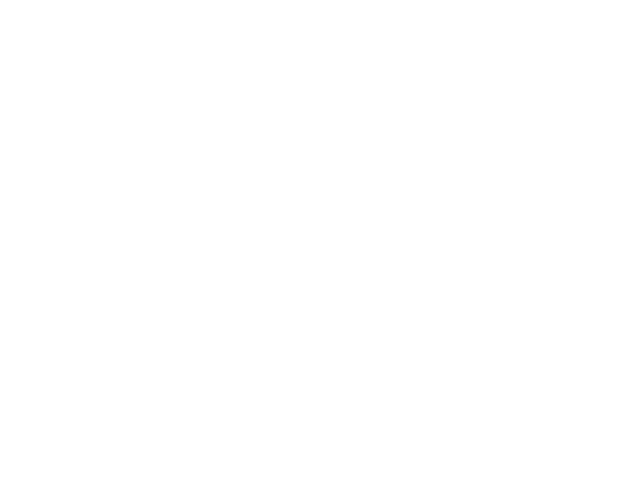

In [5]:
plt.figure()
#image = np.sqrt(np.maximum(data[0,:,:],0))
image = np.sqrt(np.maximum(np.percentile(data,95,axis=0),0))
plt.imshow(image, vmin=0, vmax=np.percentile(image,99.9))

<IPython.core.display.Javascript object>


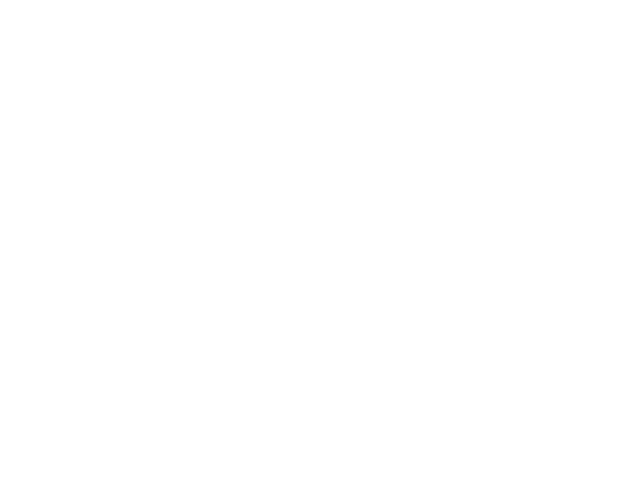

(0.0, 300.0)

In [6]:
plt.figure()
plt.plot(data[:,410,348])
plt.ylim((0,300))

[  17.75 -200.   -200.   -200.   -200.   -200.   -200.   -200.     15.25]


<IPython.core.display.Javascript object>


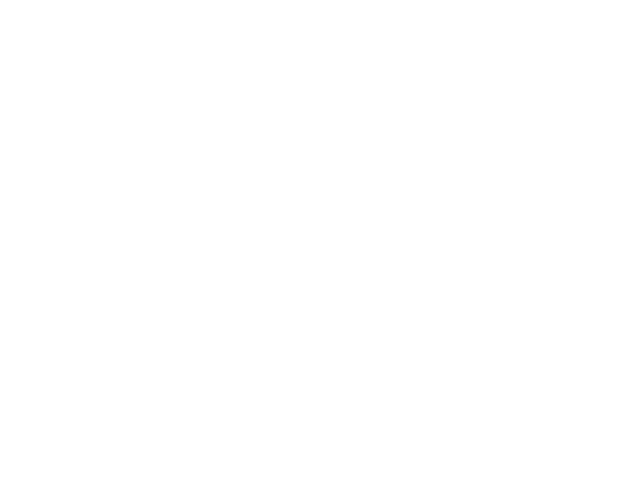

In [7]:
# Illustrate the data dropout
print(data[233:242,100,700])

# fix the data dropout
bad0 = 234  # starting index of dropout
bad1 = 241  # ending index of dropout
duration = bad1-bad0+1  # duration of dropout (number of exposures)
goodim0 = data[bad0-1,:,:] # last good image before dropout
goodim1 = data[bad1,:,:] # first good image after dropout
data2=data.copy()
weight0 = np.zeros((300))
weight1 = np.zeros((300))
for i in range(bad0,bad1):
    weight1[i] = (i-bad0+1)/(duration)
    weight0[i] = 1 - weight1[i]
    data2[i,:,:] = weight0[i]*goodim0 + weight1[i]*goodim1
data2[data2<0]=0 # Make the data nonnegative.
plt.figure()
plt.plot(weight0,label='weight0')
plt.plot(weight1,label='weight1')
plt.xlabel('time index')
#plt.xlim((bad0,bad1))
plt.legend();

<IPython.core.display.Javascript object>


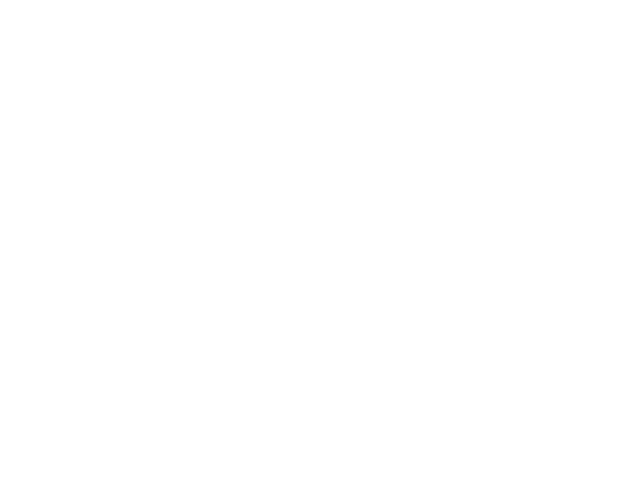

In [8]:
# Examine the interpolation at a particular spatial point.
plt.figure()
ytest=488
xtest=245
plt.plot(data[:,ytest,xtest],'.-',label='data')
plt.plot(data2[:,ytest,xtest],label='data2')
plt.xlim((bad0-50,bad1+50))
plt.ylim((-220,200))
plt.legend();

<IPython.core.display.Javascript object>


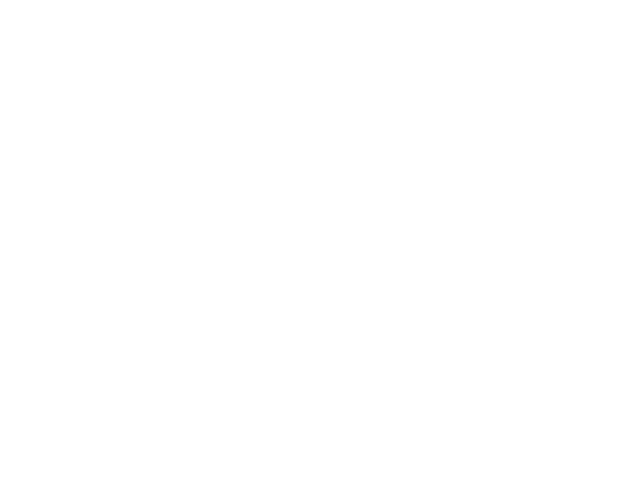

In [9]:
# Examine the middle interpolated image, to make sure it's not crazy.
plt.figure()
image = np.sqrt(np.maximum(data2[(bad0+bad1)//2,:,:],0))
plt.imshow(image, vmin=0, vmax=np.percentile(image,99.9));

In [10]:
dt = sji[0].header["CDELT3"]
exp_time = sji[0].header["EXPTIME"]
start_time = sji[0].header["DATE_OBS"]
print("SJI data cube beginning ",start_time)
print("Cadence = ",dt,' s.')
print("Exposure time = ",exp_time,' s.')

SJI data cube beginning  2013-09-13T06:36:51.620
Cadence =  3.80458  s.
Exposure time =  2.00042  s.


In [11]:
print(sji[0].header)

SIMPLE  =                    T / Written by IDL:  Sat May 20 07:04:35 2017      BITPIX  =                  -32 / Number of bits per data pixel                  NAXIS   =                    3 / Number of data axes                            NAXIS1  =                  720 /                                                NAXIS2  =                  771 /                                                NAXIS3  =                  300 /                                                EXTEND  =                    T / FITS data may contain extensions               DATE    = '2017-05-20'         / Creation UTC (CCCC-MM-DD) date of FITS header  COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    TELESCOP= 'IRIS    '           /                                                INSTRUME= 'SJI     '           /                                                DATA_LEV=              2.00000 /        

In [12]:
# Make a movie from the SJI image stack.

import celluloid
%matplotlib inline

igamma = 0.7 # image gamma
fig,ax = plt.subplots()
camera = celluloid.Camera(fig)
max_dn = np.percentile(data2,99.9)
for i in range(data2.shape[0]):
    ax.imshow(data2[i,:,:]**igamma, vmin=0, vmax=max_dn**igamma)
    camera.snap()
animation = camera.animate()
plt.close(fig)

In [13]:
%time animation.save('IRIS-SJI.mp4', fps=30)

CPU times: user 20.4 s, sys: 422 ms, total: 20.9 s
Wall time: 19.8 s


In [14]:
from IPython.display import Video
Video('IRIS-SJI.mp4')

In [15]:
# Peaklet analysis.
import peaklets as pk

import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8
